# Solving portfolio optimization as QUBO problem with QAOA

## Overview

Here we show how to solve a quadratic unconstrained binary optimization (QUBO) problem using QAOA.  Later on below we will extend this to show how to solve binary Markowitz portfolio optimization problems.

## QUBO problem

### what is QUBO?

Quadratic unconstrained binary optimization (QUBO) is a type of problem that aims to optimize a quadratic objective function using binary variables. In a QUBO problem, the objective is to find the binary variable assignments that minimize or maximize the quadratic objective function. These variables represent choices or decision variables that can be either selected (1) or not selected (0). The objective function reflects the associated costs, benefits, or constraints linked to these decisions.

QUBO is a NP-hard problem.

### An example

We illustrate the QUBO problem with a simple example. Consider minimizing the following 2x2 QUBO objective function:

$\begin{pmatrix}x_1 & x_2\end{pmatrix}\begin{pmatrix}-5& -2 \\-2 & 6\end{pmatrix}\begin{pmatrix}x_1\\x_2\end{pmatrix} = -5x_1^2 -4x_1x_2 +6x_2^2$

Clearly this is minimized at $(x_1,x_2) = (1,0)$, with corresponding objective function value of $-5$

We first convert this to an Ising Hamiltonian by mapping $x_i\rightarrow \frac{I-Z_i}{2}$

This gives

$$-\frac{5}{4}(I-Z_1)^2 -\frac{4}{4}(I-Z_1)(I-Z_2) + \frac{6}{4}(I-Z_2)^2 $$

which simplifies to

$$-\frac{1}{2}I +\frac{7}{2}Z_1   -2Z_2 -Z_1Z_2$$ 

The $-I/2$ term is simply a constant offset, so we can solve the problem by finding the minimum of 

$$\langle \psi | \frac{7}{2}Z_1 -2Z_2 -Z_1Z_2 |\psi\rangle$$ 

Note that the minimum should correspond to the computational basis state $|10\rangle$, and the corresponding true objective function value should be $-4.5$ (ignoring the offset value of $-1/2$)

## Setup

In [8]:
import tensorcircuit as tc
from tensorcircuit.applications.vags import cvar
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import clear_output
from functools import partial
import time

In [9]:
K = tc.set_backend("tensorflow")

nlayers = 2 
states = []
for i in range(4):
    states.append(f"{bin(i)[2:]:0>{2}}")

# see below for a function to generate the pauli terms and weights from the QUBO matrix

### Convert the Q-matrix to Ising Hamiltonian

In [10]:
def QUBO_to_Ising(Q):
    # input is n-by-n symmetric numpy array corresponding to Q-matrix
    # output is the components of Ising Hamiltonian

    n = Q.shape[0]

    offset = np.triu(Q, 0).sum() / 2
    pauli_terms = []
    weights = -np.sum(Q, axis=1) / 2

    for i in range(n):
        term = np.zeros(n)
        term[i] = 1
        pauli_terms.append(term)

    for i in range(n - 1):
        for j in range(i + 1, n):
            term = np.zeros(n)
            term[i] = 1
            term[j] = 1
            pauli_terms.append(term)

            weight = Q[i][j] / 2
            weights = np.concatenate((weights, weight), axis=None)

    return pauli_terms, weights, offset

In [11]:
Q = np.array([[-5, -2], [-2, 6]])
pauli_terms, weights, offset = QUBO_to_Ising(Q)
print('The pauli terms in this QUBO problem are: ', pauli_terms)
print('and correspond weights are:', weights)
print('the offset is:', offset)

The pauli terms in this QUBO problem are:  [array([1., 0.]), array([0., 1.]), array([1., 1.])]
and correspond weights are: [ 3.5 -2.  -1. ]
the offset is: -0.5


The results are consistent with our analysis.

### Ansatz

In [12]:
# Now we define the QAOA ansatz of depth nlayers
def QAOA_from_Ising(params, nlayers, pauli_terms, weights):
    nqubits = len(pauli_terms[0])
    c = tc.Circuit(nqubits)
    for i in range(nqubits):
        c.h(i)
    for j in range(nlayers):
        # cost term
        for k in range(len(pauli_terms)):
            term = pauli_terms[k]
            index_of_ones = []
            for l in range(len(term)):
                if term[l] == 1:
                    index_of_ones.append(l)
            if len(index_of_ones) == 1:
                c.rz(index_of_ones[0], theta=2 * weights[k] * params[2 * j])
            elif len(index_of_ones) == 2:
                c.exp1(
                    index_of_ones[0],
                    index_of_ones[1],
                    unitary=tc.gates._zz_matrix,
                    theta=weights[k] * params[2 * j],
                )
            else:
                raise ValueError("Invalid number of Z terms")

        for i in range(nqubits):
            c.rx(i, theta=params[2 * j + 1])  # mixing terms
    return c

### Loss function

For a general state that is the output of a quantum circuit c, we first define the corresponding loss with respect to the Ising Hamiltonian.

In [13]:
def Ising_loss(c, pauli_terms, weights):
    loss = 0.0
    for k in range(len(pauli_terms)):
        term = pauli_terms[k]
        index_of_ones = []

        for l in range(len(term)):
            if term[l] == 1:
                index_of_ones.append(l)

        if len(index_of_ones) == 1:
            delta_loss = weights[k] * c.expectation_ps(z=[index_of_ones[0]])

        else:
            delta_loss = weights[k] * c.expectation_ps(
                z=[index_of_ones[0], index_of_ones[1]]
            )

        loss += delta_loss

    return K.real(loss)

For the particular case of a circuit corresponding to a QAOA ansatz this is:

In [14]:
def QAOA_loss(nlayers, pauli_terms, weights, params):
    c = QAOA_from_Ising(params, nlayers, pauli_terms, weights)
    return Ising_loss(c, pauli_terms, weights)

In [15]:
# prepare to detele ⬇️
def QAOA_solve(pauli_terms, weights, nlayers, iterations):
    learning_rate = 1e-2

    loss_val_grad = K.value_and_grad(partial(QAOA_loss, nlayers, pauli_terms, weights))
    loss_val_grad_jit = K.jit(loss_val_grad)

    opt = K.optimizer(tf.keras.optimizers.Adam(learning_rate))

    params = K.implicit_randn(shape=[2 * nlayers], stddev=0.5)
    for i in range(iterations):
        loss, grads = loss_val_grad_jit(params)
        params = opt.update(grads, params)

    return params

In [16]:
def QUBO_QAOA(Q, ansatz, nlayers, iterations):

    pauli_terms, weights, offset = QUBO_to_Ising(Q)
    learning_rate = 1e-2

    loss_val_grad = K.value_and_grad(partial(ansatz, nlayers, pauli_terms, weights))
    loss_val_grad_jit = K.jit(loss_val_grad)

    opt = K.optimizer(tf.keras.optimizers.Adam(learning_rate))

    params = K.implicit_randn(shape=[2 * nlayers], stddev=0.5)
    for i in range(iterations):
        loss, grads = loss_val_grad_jit(params)
        params = opt.update(grads, params)

    return params

### Results

In [17]:
iterations = 500
time_start = time.time()
#final_params = QAOA_solve(pauli_terms, weights, nlayers, iterations)
final_params = QUBO_QAOA(Q, QAOA_loss, nlayers, iterations)
clear_output(wait=True)
time_end = time.time()
print("time consumed:", round(time_end - time_start, 4), 's')

time consumed: 14.3659 s


In [18]:
c = QAOA_from_Ising(final_params, nlayers, pauli_terms, weights)
probs = K.numpy(c.probability()).round(decimals=4)
#prob_dict = {states[i]: probs[i] for i in range(4)}
#prob_sorted = dict(sorted(prob_dict.items(), key=lambda item: item[1], reverse=True))
sorted_indices = np.argsort(probs)[::-1]
state_sorted = np.array(states)[sorted_indices]
prob_sorted = np.array(probs)[sorted_indices]

print("\n-------------------------------------")
print("    selection\t  |\tprobability")
print("-------------------------------------")
for i in range(len(states)):
    print("%10s\t  |\t  %.4f" % (state_sorted[i], prob_sorted[i]))
print("-------------------------------------")


-------------------------------------
    selection	  |	probability
-------------------------------------
        10	  |	  0.9862
        11	  |	  0.0122
        00	  |	  0.0011
        01	  |	  0.0005
-------------------------------------


We note that for nlayers=2 and 500 iterations, the objective function does not in this case (although it depends on the initial parameters) converge to the true value of $-4.5$.  However, the we see below that the final wavefunction does have large overlap with the desired state $|10\rangle$, so measuring the output of the QAOA algorithm will, with high probability, output the correct answer.

In [19]:
def print_output(c):
    n = c._nqubits
    N = 2**n
    x_label = r"$\left|{0:0" + str(n) + r"b}\right>$"
    labels = [x_label.format(i) for i in range(N)]
    plt.bar(range(N), c.probability())
    plt.xticks(range(N), labels, rotation=70);

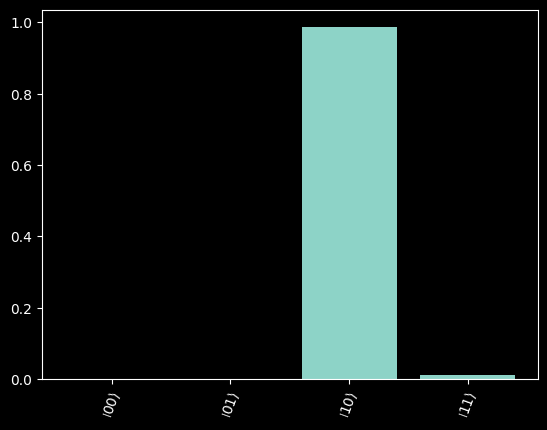

In [20]:
print_output(c)

## Portfolio problem

Consider a scenario: Xiaoming, a wise individual, has an amount of money denoted as $B$, and he intends to invest it in the stock market. The market consists of $n$ shares from which he can choose (assuming all shares have the same price). Naturally, Xiaoming aims to maximize returns while minimizing risk. Additionally, it's important to note that individuals have varying levels of risk tolerance. Xiaoming's risk tolerance is denoted as $p$. Given these factors, which shares should Xiaoming select to construct his portfolio?



## General Case

For the general QUBO case, we wish to minimize

$$ x^T Q x$$

where $x\in\{0,1\}^n$ and $Q\in\mathbb{R}^{n\times n}$ is a real symmetric matrix.

This maps to an Ising Hamiltonian 

$$\frac{1}{2}\left(\sum_{i=1}^n C_{ii} + \sum_{i<j}C_{ij}\right) I - \frac{1}{2}\sum_{i=1}^n \left(\sum_{j=1}^n C_{ij} \right)Z_i +\frac{1}{2}\sum_{i<j}C_{ij}Z_iZ_j$$

Below is a simple function which can perform this mapping:

### Solving portfolio optimization problems with QAOA

In a simple boolean Markowitz portfolio optimization problem, we wish to solve 

$$\min_{x\in\{0,1\}^n}\quad q x^T \Sigma x - \mu^T x$$

subject to 

$$ 1^T x = B$$

where 
* $n$: number of assets under consideration
* $q > 0 $: risk-appetite
* $\Sigma \in \mathbb{R}^{n\times n}$: covariance matrix of the assets
* $\mu\in\mathbb{R}^n$: mean return of the assets
* $B$: budget (i.e., total number of assets out of $n$ that can be selected)

Our first step is to convert this constrained quadratic programming problem into a QUBO.  We do this by adding a penalty factor $t$ and consider the alternative problem:

$$ \min_{x\in\{0,1\}^n}\quad q x^T \Sigma x - \mu^Tx  + t(1^Tx-B)^2$$

The variables in the linear terms $\mu^Tx = \mu_1 x_1 + \mu_2 x_2+\ldots$ can all be squared (since they are boolean variables), i.e. we can consider

$$\min_{x\in\{0,1\}^n}\quad q x^T \Sigma x - \sum_{i=1}^n\mu_i x_i^2  + t(1^Tx-B)^2$$

which is a QUBO defined by the matrix $Q$ 

$$ Q = q\Sigma -\mu\begin{pmatrix}1 & \\ & 1\\ & & \ddots\end{pmatrix} + t\begin{pmatrix}1 -2B & 1 & \ldots & 1 \\
1 & 1-2B & 1 & \ldots \\1 & 1 & 1-2B \\
\vdots\end{pmatrix}$$

i.e., we wish to mimimize

$$ x^T Q X + tB$$

and we ignore the constant term $t B$.
We can now solve this by QAOA as above.

Let us first define a function to convert portfolio data into a QUBO matrix:

In [21]:
def QUBO_from_portfolio(cov, mean, q, B, t):
    # cov: n-by-n covariance numpy array
    # mean: numpy array of means
    n = cov.shape[0]
    R = np.diag(mean)
    S = np.ones((n, n)) - 2 * B * np.diag(np.ones(n))

    Q = q * cov - R + t * S
    return Q

We can test this using the qiskit_finance package to generate some stock covariance and mean data:

*Note that this was tested with qiskit version 0.39.3 and qiskit-finance version 0.3.4.*

In [22]:
import datetime
from qiskit_finance.data_providers import RandomDataProvider

In [23]:
num_assets = 4
seed = 123

# Generate expected return and covariance matrix from (random) time-series
stocks = [("TICKER%s" % i) for i in range(num_assets)]
data = RandomDataProvider(
    tickers=stocks,
    start=datetime.datetime(2016, 1, 1),
    end=datetime.datetime(2016, 1, 30),
    seed=seed,
)
data.run()

mu = data.get_period_return_mean_vector()
sigma = data.get_period_return_covariance_matrix()

Using this mean and covariance data, we can now define our portfolio optimization problem, convert it to a QUBO matrix, and then extract the pauli terms and weights

In [24]:
q = 0.5
budget = 3  # Note that in this example, there are 4 assets, but a budget of only 3
penalty = 3

Q = QUBO_from_portfolio(sigma, mu, q, budget, penalty)
portfolio_pauli_terms, portfolio_weights, portfolio_offset = QUBO_to_Ising(Q)

In [25]:
states = []
for i in range(16):
    states.append(f"{bin(i)[2:]:0>{4}}")
print(states)

['0000', '0001', '0010', '0011', '0100', '0101', '0110', '0111', '1000', '1001', '1010', '1011', '1100', '1101', '1110', '1111']


In [26]:
# Brutely search over classical results for comparison before we run QAOA
# the results are sorted with cost
cost_dict = {}
for selection in states:
    x = np.array([int(bit) for bit in selection])
    cost_dict[selection] = np.dot(x,np.dot(Q,x))- portfolio_offset
cost_sorted = dict(sorted(cost_dict.items(), key=lambda item: item[1]))
print("\n-------------------------------------")
print("    selection\t  |\t  cost")
print("-------------------------------------")
for k, v in cost_sorted.items():
    print("%10s\t  |\t%.4f" % (k, v))
print("-------------------------------------")


-------------------------------------
    selection	  |	  cost
-------------------------------------
      1011	  |	-6.0080
      1101	  |	-6.0069
      1110	  |	-6.0060
      0111	  |	-5.9930
      1001	  |	-3.0079
      1010	  |	-3.0070
      1111	  |	-3.0069
      1100	  |	-3.0061
      0011	  |	-2.9940
      0101	  |	-2.9928
      0110	  |	-2.9922
      1000	  |	5.9930
      0001	  |	6.0062
      0010	  |	6.0069
      0100	  |	6.0079
      0000	  |	21.0070
-------------------------------------


We see that, due to the penalty, the lowest energy solutions correspond to 0111, 1011, 1101, 1110, i.e. the portfolios with only 3 assets.

In [27]:
iterations = 1000
nlayers = 3
time_start = time.time()
final_params = QAOA_solve(portfolio_pauli_terms, portfolio_weights, nlayers, iterations)
clear_output(wait=True)
time_end = time.time()
print("time consumed:", round(time_end - time_start, 4), 's')

time consumed: 55.6366 s


In [28]:
c_final = QAOA_from_Ising(
    final_params, nlayers, portfolio_pauli_terms, portfolio_weights
)
probs = K.numpy(c_final.probability()).round(decimals=4)
sorted_indices = np.argsort(probs)[::-1]
state_sorted = np.array(states)[sorted_indices]
prob_sorted = np.array(probs)[sorted_indices]

print("\n-------------------------------------")
print("    selection\t  |\tprobability")
print("-------------------------------------")
for i in range(len(states)):
    print("%10s\t  |\t  %.4f" % (state_sorted[i], prob_sorted[i]))
print("-------------------------------------")


-------------------------------------
    selection	  |	probability
-------------------------------------
      0111	  |	  0.2180
      1110	  |	  0.2156
      1101	  |	  0.2154
      1011	  |	  0.2152
      1111	  |	  0.0945
      0110	  |	  0.0063
      0101	  |	  0.0063
      0011	  |	  0.0063
      1100	  |	  0.0062
      1010	  |	  0.0062
      1001	  |	  0.0062
      0000	  |	  0.0031
      1000	  |	  0.0001
      0100	  |	  0.0001
      0010	  |	  0.0001
      0001	  |	  0.0001
-------------------------------------


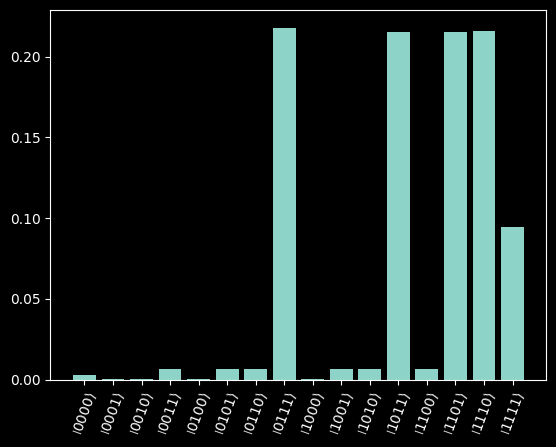

In [29]:
print_output(c_final)

### Influence of different mixers

In [ ]:
# difine an universal QAOA ansatz
def QAOA_ansatz(params, nlayers, pauli_terms, weights, mixer='standard'):
    nqubits = len(pauli_terms[0])
    c = tc.Circuit(nqubits)
    for i in range(nqubits):
        c.h(i)
    for j in range(nlayers):
        # cost term
        for k in range(len(pauli_terms)):
            term = pauli_terms[k]
            index_of_ones = []
            for l in range(len(term)):
                if term[l] == 1:
                    index_of_ones.append(l)
            if len(index_of_ones) == 1:
                c.rz(index_of_ones[0], theta=2 * weights[k] * params[2 * j])
            elif len(index_of_ones) == 2:
                c.exp1(
                    index_of_ones[0],
                    index_of_ones[1],
                    unitary=tc.gates._zz_matrix,
                    theta=weights[k] * params[2 * j],
                )
            else:
                raise ValueError("Invalid number of Z terms")
            
        # standard mixer term
        if mixer is 'normal':
            for i in range(nqubits):
                c.rx(i, theta=params[2 * j + 1])  
        
        # ring mixer
        if mixer is 'ring':
            for i in range(nqubits-1):
                c.exp1(
                    index_of_ones[i],
                    index_of_ones[i+1],
                    unitary=tc.gates._xx_matrix,
                    theta=params[2 * j + 1],
                )
            c.exp1(
                    index_of_ones[-1],
                    index_of_ones[0],
                    unitary=tc.gates._xx_matrix,
                    theta=params[2 * j + 1],
            )
        
        # parity ring mixer
        if mixer is 'par_ring':
            half = int(nqubits / 2)
            for i in range(half+1): # even
                c.exp1(
                    index_of_ones[2*i-1],
                    index_of_ones[2*i],
                    unitary=tc.gates._xx_matrix,
                    theta=params[2 * j + 1],
                )
            for i in range(half - 1): # odd
                c.exp1(
                    index_of_ones[2*i],
                    index_of_ones[2*i+1],
                    unitary=tc.gates._xx_matrix,
                    theta=params[2 * j + 1 + half],
                )
            if 2*half < nqubits:
                c.exp1(
                    index_of_ones[2*half],
                    index_of_ones[2*half+1],
                    unitary=tc.gates._xx_matrix,
                    theta=params[2 * j + 1 + half],
                )
        
        # full mixer
        if mixer is 'full':
            pass
        # 
        if mixer is 'QAMPA':
            pass
    return c


### Use CVaR

In [177]:
def cvar_test(r, p, percent):

    rs = sorted(
        [(i, j) for i, j in enumerate(r)], key=lambda s: -s[1]
    )  # larger to smaller
    sump = 0.0  # the sum of probability
    count = 0
    cvar_result = 0.0
    while sump < percent:
        if round(sump + p[rs[count][0]], 7) > percent:
            cvar_result += r[rs[count][0]] * (percent - sump)
            count += 1
            break
        else:
            sump += p[rs[count][0]]
            cvar_result += r[rs[count][0]] * p[rs[count][0]]
            count += 1

    cvar_result /= percent
    return cvar_result

In [178]:
def cvar_from_circuit(circuit, num_samples, Q, portfolio_offset, alpha):
    from tensorcircuit.applications.vags import cvar
    from tensorcircuit.quantum import measurement_results

    s = circuit.state()
    results = measurement_results(s, counts=num_samples, format="count_dict_bin") # get readouts
    results = {k: v/num_samples for k, v in results.items()}
    values = [] # passed to cvar
    probability = [] # passed to cvar
    for k, v in results.items():
        x = np.array([int(bit) for bit in k])
        values.append(np.dot(x,np.dot(Q,x))- portfolio_offset)
        probability.append(v)
    cvar_value = cvar_test(values, probability, alpha)
    return cvar_value

In [198]:
cvar_value = cvar_from_circuit(c_final, 1000, Q, portfolio_offset, 0.2)
print(cvar_value)

-3.67575599844874
